In [29]:
import io
import os
import gc
import re
import pickle
import random
import termcolor
import warnings
import shutil
from collections import Counter
from functools import partial
from datetime import datetime
from dataclasses import dataclass
from pathlib import Path
from typing import List

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import  accuracy_score

import lightgbm as lgbm
from joblib import dump, load

In [2]:
#!pip install -q git+https://github.com/facebookresearch/fastText.git
#!pip install -q texthero

In [3]:
import fasttext
import texthero
from nltk.corpus import stopwords

In [4]:
stopwords_list = stopwords.words('english') + stopwords.words('french')

# Config

In [5]:
DEBUG = True
SAVE_PATH = None
SEED = 42
NOW = datetime.strftime(datetime.now() , "%m%d")

SAVE_PATH = Path(f'../input/')
SAVE_PATH.mkdir(exist_ok=True)

NUM_WORKERS = os.cpu_count()

print("DEBUG:\t", DEBUG)
print("SAVE_PATH:\t", SAVE_PATH)
print("NUM_WORKERS:\t", NUM_WORKERS)

DEBUG:	 True
SAVE_PATH:	 ../input
NUM_WORKERS:	 12


In [6]:
# @dataclass
# class Config:
#     max_seq_len:int = 192
#     num_fold:int = 5

#     lr:float = 3e-5
#     batch_size: int = 128
#     num_epoch:int = 10
#     max_grad_norm:float = 1.0
#     gradient_accumulation_steps: int = 1
#     warmup_steps: int = 0
#     weight_decay: float = 0.0
#     adam_beta1: float = 0.9
#     adam_beta2: float = 0.999
#     adam_epsilon: float= 1e-8
#     max_grad_norm: float = 1.0

#     save_top_k:int = 1

#     def __post_init__(self):
#         pass


# cfg = Config()
# cfg

# Helper

In [7]:
def save_pkl(dir, name, obj):
    dir.mkdir(exist_ok=True)
    with open(dir / name, 'wb') as f:
        pickle.dump(obj, f)

def load_pkl(dir, name):
    with open(dir / name, 'rb') as f:
        return pickle.load(f)

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

In [8]:
set_seed(SEED)

# Load Data

In [9]:
train_df = pd.read_csv("./input/Train.csv")
test_df = pd.read_csv("./input/Test.csv")

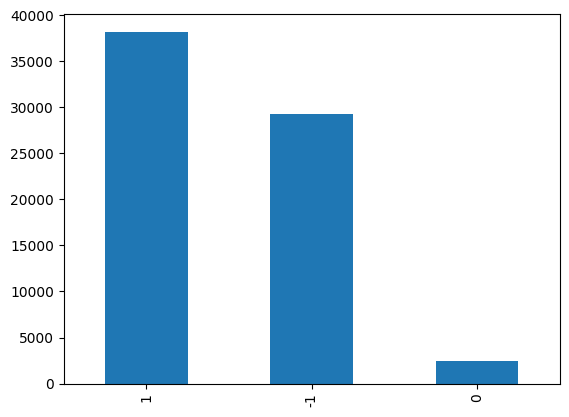

In [10]:
train_df['label'].value_counts().plot(kind='bar')

In [11]:
LABEL2ID = {label:i for i, label in enumerate(train_df['label'].unique())}
ID2LABEL = {v:k for k, v in LABEL2ID.items()}

train_df['label_ids'] = train_df['label'].map(LABEL2ID)

In [12]:
train_df

,ID,text,label,label_ids
0,ID_13P0QT0,3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...,-1,0
1,ID_SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kressi,-1,0
2,ID_V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1,0
3,ID_U0TTYY8,ak slouma,1,1
4,ID_68DX797,entom titmanou lina a7na 3iid moubarik a7na ch...,-1,0
...,...,...,...,...
69995,ID_ZRSR7TZ,pff bayna beli kbira f wejhakk yakhiii rouhi r...,-1,0
69996,ID_QNQVEIH,aman lmara jeya zidou t3am9ou fel a7deeth akth...,-1,0
69997,ID_LJ2K9MD,winha nakhtabha hhhhh,-1,0
69998,ID_5RZ1T7I,fachel enta w houwa,-1,0


In [13]:
train_targets = train_df['label_ids'].values

In [14]:
all_texts = pd.concat([train_df['text'].str.lower(), test_df['text'].str.lower()])

In [15]:
all_texts = texthero.remove_stopwords(all_texts, stopwords_list)
all_texts = texthero.remove_whitespace(all_texts)

In [26]:
all_texts

0        3sbaaaaaaaaaaaaaaaaaaaa lek seim riahi 3sbaaaa...
1                cha3eb fey9elkoum menghir ta7ayoul kressi
2        bereau degage nathef ya slim walahi ya7chiw fi...
3                                                ak slouma
4        entom titmanou lina a7na 3iid moubarik a7na ch...
                               ...                        
29995                                         ihebekch raw
29996    nchallah rabi m3ak w iwaf9ek 7abit nes2l win w...
29997    slim rabi m3ak w e5edem w 5alli l7ossed lemnay...
29998    bara 5alis rouhik yizi mitbal3it jam3iya hlaki...
29999    rabi m3aaaak ya khawlaaa n7ebouuuuk rana barsh...
Name: text, Length: 100000, dtype: object

# Train Fasttext

In [16]:
with open("../input/data.txt", "w") as f:
    for line in all_texts:
        f.write(line+"\n")

In [17]:
%%time
fattext_model = fasttext.train_unsupervised("../input/data.txt", model='skipgram', dim=300, wordNgrams=2, epoch=10)

Read 1M words
Number of words:  18460
Number of labels: 0
Progress:  99.2% words/sec/thread:   24527 lr:  0.000379 avg.loss:  2.085313 ETA:   0h 0m 0s

CPU times: user 7min 5s, sys: 1.11 s, total: 7min 6s
Wall time: 40.4 s


Progress: 100.0% words/sec/thread:   24522 lr:  0.000000 avg.loss:  2.082787 ETA:   0h 0m 0s


In [18]:
all_features = [fattext_model.get_sentence_vector(text) for text in tqdm(all_texts)]
all_features = np.vstack(all_features)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [38]:
all_features

array([[-0.00106795,  0.0016102 , -0.06782615, ..., -0.03830292,
         0.01859627,  0.03411271],
       [-0.02859659, -0.02939982, -0.04511665, ..., -0.05565228,
         0.07616689,  0.02878306],
       [-0.02287821, -0.02956938, -0.04143572, ..., -0.00525936,
         0.01513351, -0.00029403],
       ...,
       [-0.04776379, -0.03106091, -0.08061023, ..., -0.02251478,
         0.02285151,  0.00682307],
       [ 0.00560036, -0.03767352, -0.06461616, ..., -0.03398087,
         0.00729393, -0.01636938],
       [-0.05200912, -0.00057337, -0.09549328, ..., -0.03529743,
         0.01945952,  0.03119011]], dtype=float32)

In [41]:
# Save the model to a file
fattext_model.save_model('transformer.pkl')

In [42]:
loaded_model = fasttext.load_model('transformer.pkl')

In [43]:
result =  [loaded_model.get_sentence_vector(text) for text in tqdm(all_texts)]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [39]:
all_features = np.vstack(result)

In [40]:
all_features

array([[-0.00106795,  0.0016102 , -0.06782615, ..., -0.03830292,
         0.01859627,  0.03411271],
       [-0.02859659, -0.02939982, -0.04511665, ..., -0.05565228,
         0.07616689,  0.02878306],
       [-0.02287821, -0.02956938, -0.04143572, ..., -0.00525936,
         0.01513351, -0.00029403],
       ...,
       [-0.04776379, -0.03106091, -0.08061023, ..., -0.02251478,
         0.02285151,  0.00682307],
       [ 0.00560036, -0.03767352, -0.06461616, ..., -0.03398087,
         0.00729393, -0.01636938],
       [-0.05200912, -0.00057337, -0.09549328, ..., -0.03529743,
         0.01945952,  0.03119011]], dtype=float32)

In [19]:
all_features

array([[-0.00106795,  0.0016102 , -0.06782615, ..., -0.03830292,
         0.01859627,  0.03411271],
       [-0.02859659, -0.02939982, -0.04511665, ..., -0.05565228,
         0.07616689,  0.02878306],
       [-0.02287821, -0.02956938, -0.04143572, ..., -0.00525936,
         0.01513351, -0.00029403],
       ...,
       [-0.04776379, -0.03106091, -0.08061023, ..., -0.02251478,
         0.02285151,  0.00682307],
       [ 0.00560036, -0.03767352, -0.06461616, ..., -0.03398087,
         0.00729393, -0.01636938],
       [-0.05200912, -0.00057337, -0.09549328, ..., -0.03529743,
         0.01945952,  0.03119011]], dtype=float32)

In [20]:
train_features = all_features[:len(train_df)]
test_features = all_features[len(train_df):]

In [21]:
test_features

array([[ 0.00514885, -0.01693812, -0.00471918, ..., -0.03382568,
        -0.00043359, -0.03012971],
       [-0.0312585 ,  0.03899667, -0.07935634, ..., -0.03053857,
         0.0167608 , -0.06937312],
       [-0.05222502,  0.01429251, -0.09308972, ...,  0.01405543,
         0.00218351,  0.0535922 ],
       ...,
       [-0.04776379, -0.03106091, -0.08061023, ..., -0.02251478,
         0.02285151,  0.00682307],
       [ 0.00560036, -0.03767352, -0.06461616, ..., -0.03398087,
         0.00729393, -0.01636938],
       [-0.05200912, -0.00057337, -0.09549328, ..., -0.03529743,
         0.01945952,  0.03119011]], dtype=float32)

# make cv

In [22]:
cv = list(StratifiedKFold(n_splits=5).split(train_df, train_df['label_ids']))

In [23]:
LGBM_PARAMS = {
    "n_estimators": 10000,

    "max_depth": 6,
    
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 3,

    'random_state': 42,
}

In [24]:
%%time
val_scores = []
val_preds = np.zeros((len(train_df), len(ID2LABEL)), dtype="float32")
test_preds = np.zeros((5, len(test_df), len(ID2LABEL)), dtype="float32")

for fold in range(5):
    print('='*30)
    print(f'======fold: {fold} start======')

    trn_idx, val_idx = cv[fold]

    trn_features, val_features = train_features[trn_idx], train_features[val_idx]
    trn_targets, val_targets = train_targets[trn_idx], train_targets[val_idx]

    model = lgbm.LGBMClassifier(**LGBM_PARAMS)
    
    model.fit(
        X=trn_features,
        y=trn_targets,
        eval_set=[(val_features, val_targets)],
        early_stopping_rounds=50,
        verbose=50,
    )

    val_pred = model.predict(val_features)
    score = accuracy_score(val_targets, val_pred)

    print(f"score {score:.4f}")

    val_preds[val_idx] = model.predict_proba(val_features)
    test_preds[fold] = model.predict_proba(test_features)

======fold: 0 start======
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.496156
[100]	valid_0's multi_logloss: 0.479572
[150]	valid_0's multi_logloss: 0.475085
[200]	valid_0's multi_logloss: 0.472697
[250]	valid_0's multi_logloss: 0.47202
[300]	valid_0's multi_logloss: 0.473192
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 0.471863
score 0.8007
======fold: 1 start======
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. C

In [25]:
print(f"all oof score {accuracy_score(train_targets, np.argmax(val_preds, axis=-1)):.4f}")

all oof score 0.8011


In [25]:
 val_preds[val_idx]

array([[0.72182477, 0.252643  , 0.02553223],
       [0.25505322, 0.37598354, 0.36896324],
       [0.02697412, 0.9708654 , 0.00216047],
       ...,
       [0.7491122 , 0.18198207, 0.0689057 ],
       [0.9092017 , 0.07787899, 0.01291932],
       [0.03604629, 0.9597934 , 0.00416029]], dtype=float32)

In [26]:
val_features

array([[-0.00274511, -0.03068905, -0.05089149, ..., -0.02671383,
         0.01810639,  0.01648952],
       [ 0.0073285 , -0.01267307, -0.0471139 , ...,  0.00379582,
        -0.00870031,  0.01137399],
       [-0.01586012,  0.00633105, -0.08112895, ..., -0.08650197,
         0.07804128,  0.0262604 ],
       ...,
       [ 0.04470783,  0.04509737, -0.08074663, ..., -0.09336849,
         0.00830155, -0.04667057],
       [ 0.00911353,  0.00704008, -0.03670062, ..., -0.02367837,
        -0.02304896,  0.00376766],
       [ 0.0193888 ,  0.01706127, -0.00213409, ..., -0.00186663,
         0.03647269,  0.00310219]], dtype=float32)

In [27]:
model.predict(val_features)

array([0, 1, 1, ..., 0, 0, 1])

In [25]:
### Saving models like this return error while deploying immediately

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [26]:

# load the saved model object from the binary file
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [27]:
model.predict(val_features)

array([0, 1, 1, ..., 0, 0, 1])

In [24]:
### Saving models like this first loads the model and returns error while deploying immediately. I wonder why? 
### It is understandable for the displayed interface of gcp to return error while the prediction button is engange
### as we only save the test predictions.

save_pkl(Path("./"), "test_preds.pkl", test_preds)


In [ ]:
##### The deployment is very positive with toy models. For all these, it is very unlikely the error is due to 
#### doing the POST and wrong 